In this notebook I am [Stumpy](https://stumpy.readthedocs.io/en/latest/) for time series data mining tasks. 

Stumpy is a powerful and scalable library which computes matrix profile and can be used for a variety of tasks such as:

* pattern/motif (approximately repeated subsequences within a longer time series) discovery
* anomaly/novelty (discord) discovery
* semantic segmentation
* density estimation

A matrix profile is a vector that stores the z-normalized Euclidean distance between any subsequence within a time series and its nearest neigbor. Subsequence is a part or section of the full time series. Each subsequence can have a different sequence length and compare any two subsequences of the same length. Euclidean Distance is the straight-line distance between two points. Distance Profile is a vector of pairwise Euclidean distances where one subsequence is the same (reference subsequence) while the second subsequence changes in a sliding window manner to compute the Euclidean distance for each window. Matrix profile is only interested in storing the smallest non-trivial distances from each distance profile, which significantly reduces the spatial complexity to O(n). Please refer [here](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html) for more information.

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import suptitle
import matplotlib.style as style
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt
from IPython.display import display, HTML
import stumpy

warnings.filterwarnings('ignore')
# Set some parameters
pd.set_option('display.width',170, 'display.max_rows',10, 'display.max_columns',30)
%matplotlib inline
plt.style.use('bmh')

In [2]:
# Automatically resize and create the plots 
def change_plot_size(width, height, plt):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = width
    fig_size[1] = height
    plt.rcParams["figure.figsize"] = fig_size
    plt.rcParams['xtick.direction'] = 'out'

### Download data and select opning price

In [3]:
from datetime import datetime
import pandas_datareader.data as web
import configparser
settings = configparser.ConfigParser()
settings.read('../data/processed/config.ini')
api_key = settings.get('AlphaVantage', 'api_key')
start = datetime(2016, 1, 1)
end = datetime.now()
f = web.DataReader("UNH", "av-daily", start=start,  end=end, api_key= api_key)
df = f['open'].to_frame().reset_index()
df.columns =['index','open']
df['index'] = pd.to_datetime(df['index'])
df.set_index("index", inplace=True)


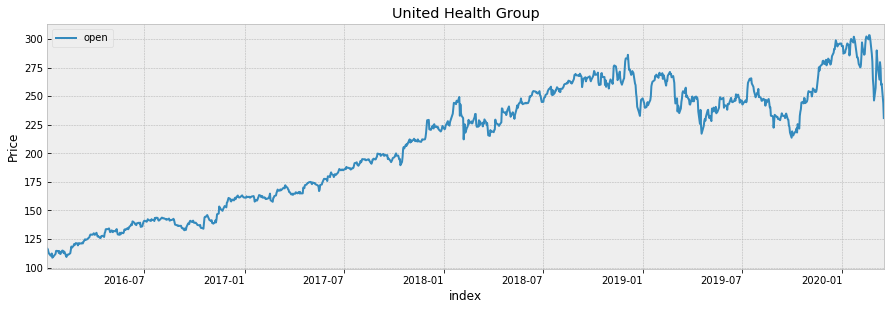

In [4]:
change_plot_size(15, 5, plt)
ax = df.plot(label='Open')
ax.set_ylabel('Price')
plt.legend(loc="upper left")
plt.title('United Health Group')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
plt.show()

#### Novelty in time series is non-repeated subsequences found within a longer time series. The matrix profile index indicates the subsequence that does not have nearest neighbor that resembles itself. 

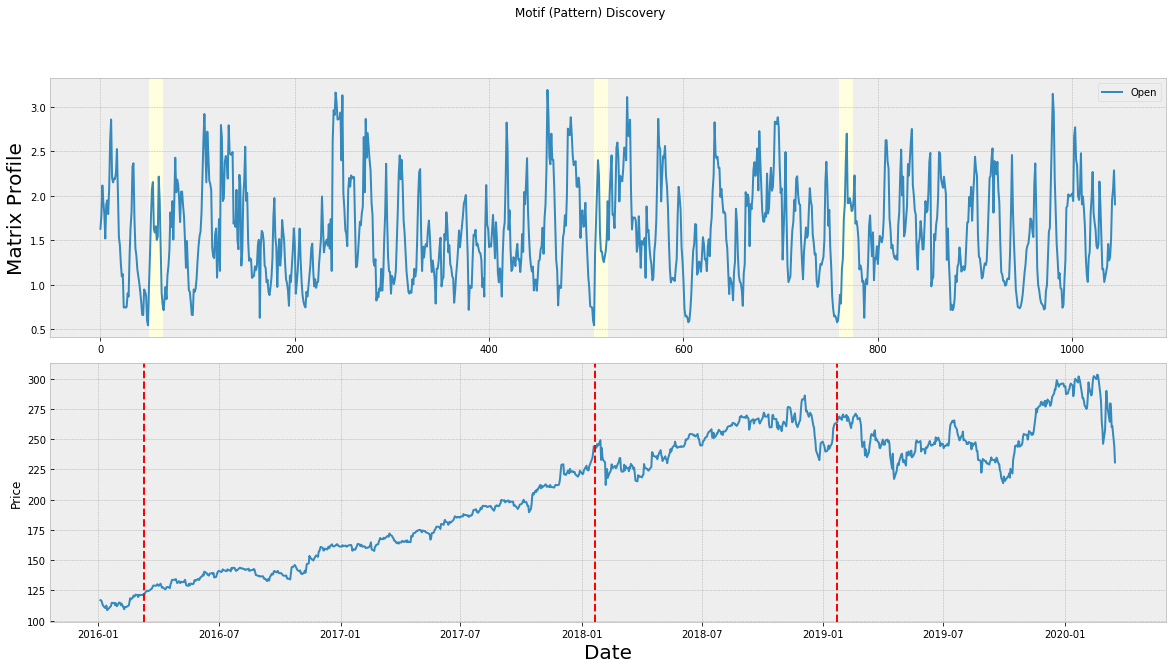

In [5]:
# Matrix Profile
m = 14
mp = stumpy.stump(df['open'], m)

change_plot_size(20, 10, plt)
fig, axs = plt.subplots(2, gridspec_kw={'hspace': 0.1})
plt.suptitle('Motif (Pattern) Discovery')
axs[0].plot(mp[:, 0], label='Open')

axs[0].set_ylabel('Matrix Profile', fontsize='20')
rect = Rectangle((50, 0), m, 40, facecolor='lightyellow')
axs[0].add_patch(rect)
rect = Rectangle((508, 0), m, 40, facecolor='lightyellow')
axs[0].add_patch(rect)
rect = Rectangle((760, 0), m, 40, facecolor='lightyellow')
axs[0].add_patch(rect)


axs[1].plot(df.index,df.values)
axs[1].set_ylabel('Price', rotation = 'vertical')
axs[1].axvline(x='2016-03-10', linestyle="dashed", color = 'red')
axs[1].axvline(x='2018-01-21', linestyle="dashed", color = 'red')
axs[1].axvline(x='2019-01-21', linestyle="dashed", color = 'red')
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=0)
axs[1].set_xlabel('Date', fontsize='20')
axs[0].legend(loc="upper right")
plt.show()

##### The global minima (vertical dashed lines) from the matrix profile correspond to the locations of the three subsequences that make up the motif or pattern. Interestingly, the motif pairs happened on 21st January 2018 and 21st January 2019. And the exact z-normalized Euclidean distance between these two subsequences is:

In [6]:
mp[:, 0].min()

0.542542349980729

In [7]:
np.argwhere(mp[:, 0] == mp[:, 0].min()).flatten()[0]

508

So, this distance isn’t zero since we saw that the three subsequences aren’t an identical match but, relative to the rest of the matrix profile (i.e., compared to either the mean or median matrix profile values), we can understand that this motif is a significant match.

### Find Anomalies

Conversely, the maximum value in the matrix profile is:

In [8]:
mp[:, 0].max()

3.1877894517159153

The matrix profile index also tells us which subsequence within the time series does not have nearest neighbor that resembles itself:

In [9]:
np.argwhere(mp[:, 0] == mp[:, 0].max()).flatten()[0]

460

The subsequence located at this global maximum is also referred to as a discord, novelty, or anomaly:

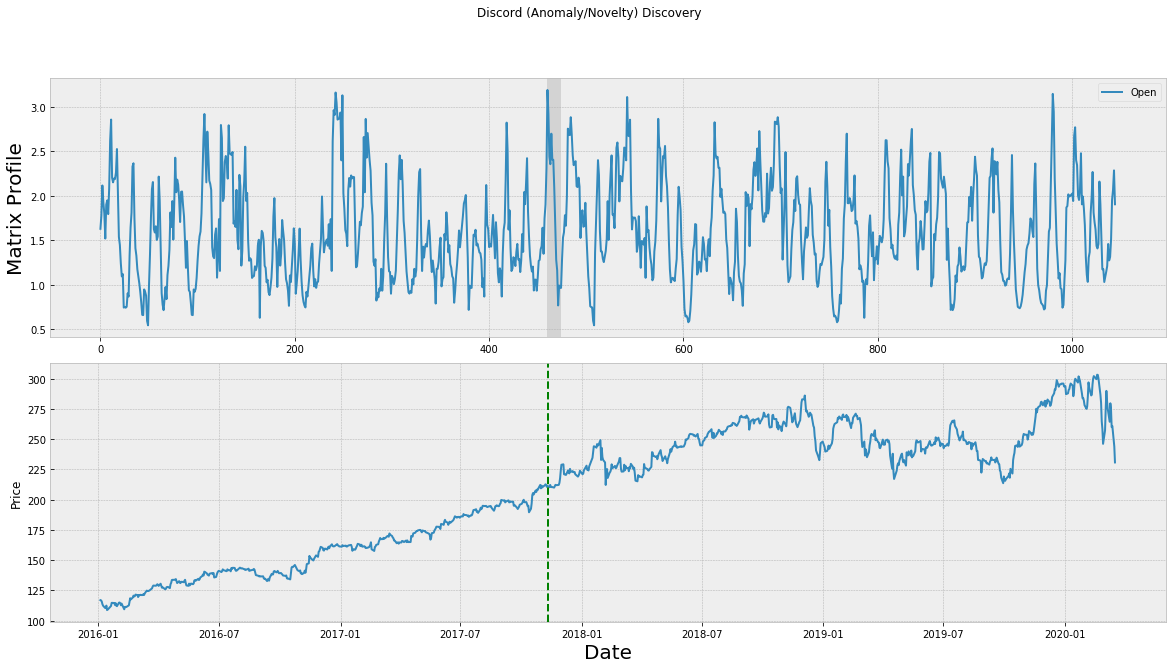

In [10]:
change_plot_size(20, 10, plt)
fig, axs = plt.subplots(2, gridspec_kw={'hspace': 0.1})
plt.suptitle('Discord (Anomaly/Novelty) Discovery')
axs[0].plot(mp[:, 0], label='Open')

axs[0].set_ylabel('Matrix Profile', fontsize='20')
rect = Rectangle((460, 0), m, 40, facecolor='lightgray')
axs[0].add_patch(rect)

axs[1].plot(df.index,df.values)
axs[1].set_ylabel('Price', rotation = 'vertical')
axs[1].axvline(x='2017-11-10', linestyle="dashed", color = 'green')
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=0)
axs[1].set_xlabel('Date', fontsize='20')
axs[0].legend(loc="upper right")
plt.show()

### Segmentation Discovery

In [11]:
L = 14
cac, regime_locations = stumpy.fluss(mp[:, 1], L=L, n_regimes=1, excl_factor=1)

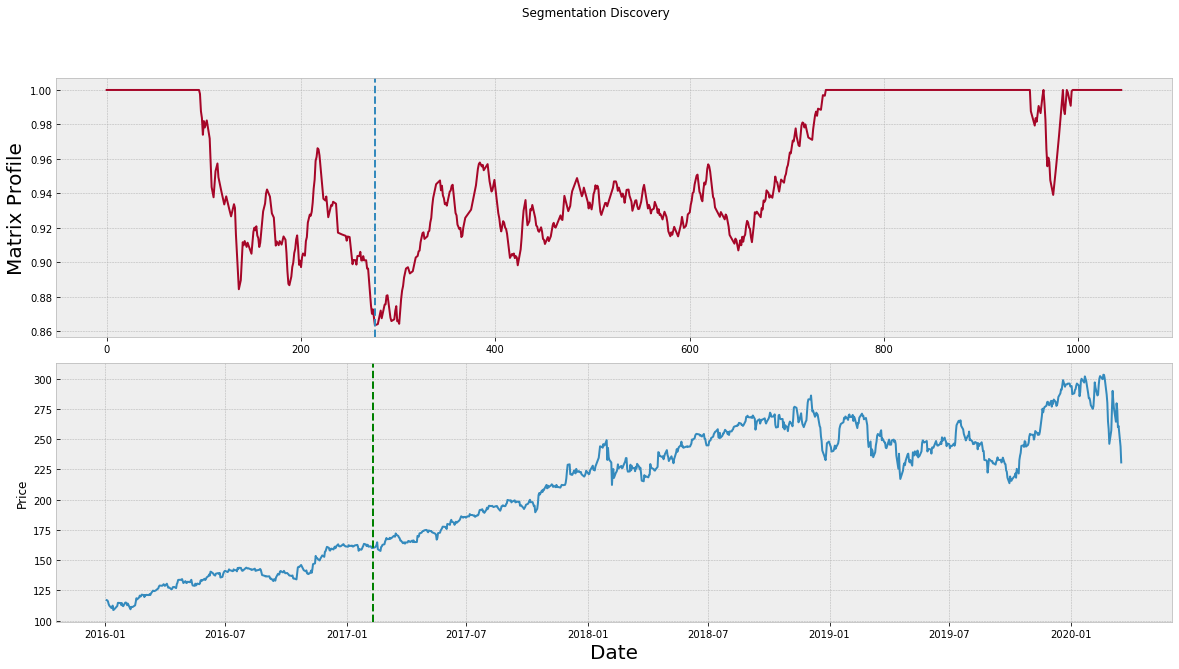

In [12]:
fig, axs = plt.subplots(2, gridspec_kw={'hspace': 0.1})
plt.suptitle('Segmentation Discovery')
axs[0].plot(range(cac.shape[0]), cac, color='C1')
axs[0].axvline(x=regime_locations[0], linestyle="dashed")
axs[0].set_ylabel('Matrix Profile', fontsize='20')

axs[1].plot(df.index,df.values)
axs[1].set_ylabel('Price', rotation = 'vertical')
axs[1].axvline(x='2017-02-10', linestyle="dashed", color = 'green')
axs[1].set_xlabel('Date', fontsize='20')
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=0)
plt.show()

In the plot above, we see that the segmentation between the two regimes occurs around 10th February 2017 (vertical dotted line) where the patterns from the first regime don’t cross over to the second regime.

The “arc curve” is calculated by sliding along the time series and simply counting the number of times other patterns haved “crossed over” that specific time point (i.e., “arcs”). To compute the “arc curve” and determine the location of the regime change, we can directly call the Fast Low-cost Unipotent Semantic Segmentation (fluss) function. 
However, note that fluss requires the following inputs:

* the matrix profile indices mp[:, 1] (not the matrix profile distances)
* an appropriate subsequence length, L (for convenience, we’ll just choose it to be equal to the window size, m=210)
* the number of regimes to search for (2 regions in this case)
* an exclusion factor to nullify the beginning and end of the arc curve (anywhere between 1-5 is reasonable according to the [paper](https://www.cs.ucr.edu/~eamonn/Segmentation_ICDM.pdf))

Fluss returns something called the “corrected arc curve” (CAC), which normalizes the fact that there are typically less arcs crossing over a time point near the beginning and end of the time series and more potential for cross overs near the middle of the time series. Additionally, fluss returns the regimes or location(s) of the dotted line(s).